In [1]:
import tifffile
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt

Load QPTIFF with `tifffile.TiffFile` to prevent loading all the image array at once, taking massive RAM.

In [2]:
qptiff = tifffile.TiffFile('../Steph_redo/cHL_revision_1_20250317_Scan1.er.qptiff')

In [10]:
qptiff.series[0].levels

[<tifffile.TiffPageSeries 0 qpi>,
 <tifffile.TiffPageSeries 0 qpi>,
 <tifffile.TiffPageSeries 0 qpi>,
 <tifffile.TiffPageSeries 0 qpi>,
 <tifffile.TiffPageSeries 0 qpi>,
 <tifffile.TiffPageSeries 0 qpi>,
 <tifffile.TiffPageSeries 0 qpi>]

Show the memory usage of `qptiff`. 

In [10]:
size_kb = sys.getsizeof(qptiff)/1024
size_mb = size_kb/1024

print(f"qptiff memory usage: {sys.getsizeof(qptiff)} bytes.")
print(f"qptiff memory usage: {size_kb:.2f} KB.")
print(f"qptiff memory usage: {size_mb:.4f} MB.")

qptiff memory usage: 48 bytes.
qptiff memory usage: 0.05 KB.
qptiff memory usage: 0.0000 MB.


Check out the structure of the QPTIFF.

In [3]:
# Get number of pages and series
print(f"Number of pages: {len(qptiff.pages)}")
print(f"Number of series: {len(qptiff.series)}")

# Check file type
print(f"Is OME-TIFF: {qptiff.is_ome}")
print(f"Is ImageJ: {qptiff.is_imagej}")
print(f"Is Micromanager: {qptiff.is_micromanager}")
print(f"Byte order: {qptiff.byteorder}")  # '>' for big-endian, '<' for little-endian

Number of pages: 290
Number of series: 4
Is OME-TIFF: False
Is ImageJ: False
Is Micromanager: False
Byte order: <


It appears that:
- Series 0: the actual image array with a pyramidal structure of 7 levels. 
- Series 1: something with 3 channels, potentially RGB
- Series 2: something with 3 channels, potentially RGB
- Series 3: something with 3 channels, potentially RGB

In [4]:
# Loop through all series
for i, series in enumerate(qptiff.series):
    print(f"\nSeries {i}:")
    print(f"  Shape: {series.shape}")
    print(f"  Dtype: {series.dtype}")
    print(f"  Axes: {series.axes}")
    print(f"  Kind: {getattr(series, 'kind', 'N/A')}")
    print(f"  Levels: {len(getattr(series, 'levels', []))}")


Series 0:
  Shape: (41, 66960, 33600)
  Dtype: uint16
  Axes: CYX
  Kind: qpi
  Levels: 7

Series 1:
  Shape: (261, 131, 3)
  Dtype: uint8
  Axes: YXS
  Kind: qpi
  Levels: 1

Series 2:
  Shape: (2736, 1536, 3)
  Dtype: uint8
  Axes: YXS
  Kind: qpi
  Levels: 1

Series 3:
  Shape: (720, 960, 3)
  Dtype: uint8
  Axes: YXS
  Kind: qpi
  Levels: 1


In [13]:
# Look at the first few pages (limit to avoid excessive output)
for i, page in enumerate(qptiff.pages):  # Examine first 5 pages
    print(f"\nPage {i}:")
    print(f"  Shape: {page.shape}")
    print(f"  Dtype: {page.dtype}")
    print(f"  Axes: {page.axes}")
    print(f"  Resolution: {page.resolution}")
    print(f"  Compression: {page.compression}")
    
    # Print a few key tags (if available)
    important_tags = ['ImageDescription', 'ResolutionUnit', 'XResolution', 'YResolution']
    print("  Key tags:")
    for tag in important_tags:
        if tag in page.tags:
            tag_value = page.tags[tag].value
            # Truncate long values
            if isinstance(tag_value, str) and len(tag_value) > 50:
                tag_value = tag_value[:50] + "..."
            print(f"    {tag}: {tag_value}")


Page 0:
  Shape: (66960, 33600)
  Dtype: uint16
  Axes: YX
  Resolution: (19731.009826531175, 19731.009826531175)
  Compression: 5
  Key tags:
    ImageDescription: <?xml version="1.0" encoding="utf-16"?>
<PerkinEl...
    ResolutionUnit: 3
    XResolution: (4294967295, 217676)
    YResolution: (4294967295, 217676)

Page 1:
  Shape: (66960, 33600)
  Dtype: uint16
  Axes: YX
  Resolution: (19731.009826531175, 19731.009826531175)
  Compression: 5
  Key tags:
    ImageDescription: <?xml version="1.0" encoding="utf-16"?>
<PerkinEl...
    ResolutionUnit: 3
    XResolution: (4294967295, 217676)
    YResolution: (4294967295, 217676)

Page 2:
  Shape: (66960, 33600)
  Dtype: uint16
  Axes: YX
  Resolution: (19731.009826531175, 19731.009826531175)
  Compression: 5
  Key tags:
    ImageDescription: <?xml version="1.0" encoding="utf-16"?>
<PerkinEl...
    ResolutionUnit: 3
    XResolution: (4294967295, 217676)
    YResolution: (4294967295, 217676)

Page 3:
  Shape: (66960, 33600)
  Dtype: uint16


The fact that the QPTIFF has $41 \times 7 + 1 + 1 + 1 = 290$ pages. The pages points to the actual images arrays. Printing out the structure of each page showed that the first 41 pages (0-40) are the full resolution marker images. Then page 41 is the (261,131,3) array. Starting from page 42, it's the 2nd resolution layer of the marker images. Therefore, the structure of the pages should be:

In [12]:
from anytree import Node, RenderTree

root = Node("qptiff.pages")
child1 = Node("Marker image level 1", parent = root)
child2 = Node("(261,131,3)", parent = root)
child3 = Node("All sub-levels of marker image", parent = root)
child4 = Node("(2736,1536,3)", parent = root)
child5 = Node("(720,960,3)", parent = root)

for pre, _, node in RenderTree(root):
    print(f"{pre}{node.name}")

qptiff.pages
├── Marker image level 1
├── (261,131,3)
├── All sub-levels of marker image
├── (2736,1536,3)
└── (720,960,3)


Now let's check out what those 3 channel arrays are

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fe793041e20>)

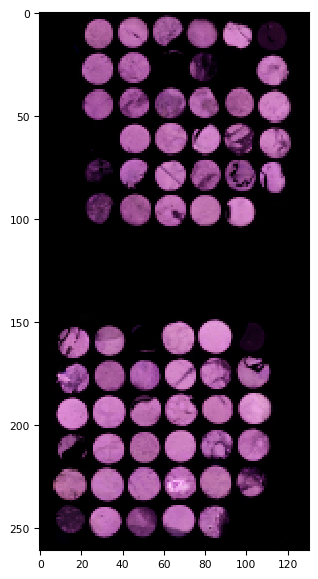

In [22]:
tifffile.imshow(qptiff.series[1].asarray())

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fe7abadc700>)

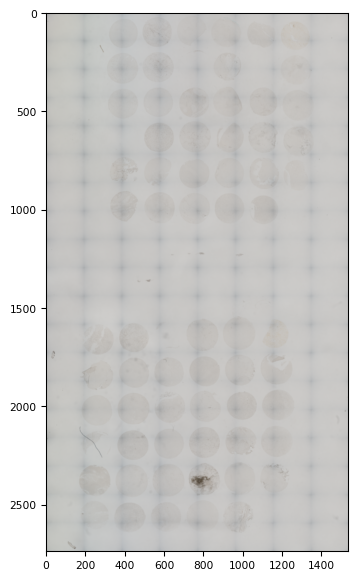

In [ ]:
tifffile.imshow(qptiff.series[2].asarray())

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fe7aba42550>)

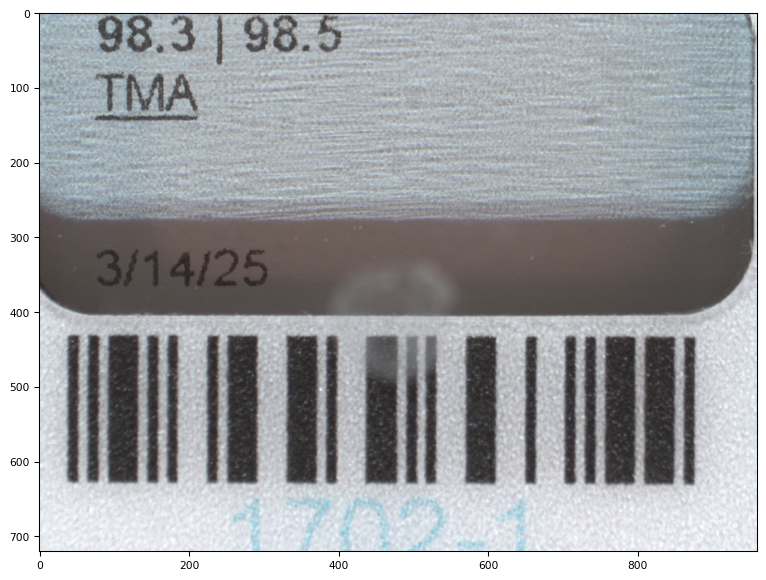

In [16]:
tifffile.imshow(qptiff.series[3].asarray())